In [9]:
import networkx as nx
import numpy as np
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
from collections import defaultdict
from gensim.models import Word2Vec
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

# Pipeline

### Data Loader

We need to load networks into memory. Usually networks are organized as pairs of nodes. And sometimes different edges have different weights. Hence, we use networkx.DiGraph to store such structure information and attributes.

In [10]:
def load_data(file_name):
    """
    read edges from an edge file
    """
    edges = list()
    df = pd.read_csv(file_name)
    for idx, row in df.iterrows():
        user_id, friends = row["user_id"], eval(row["friends"])
        for friend in friends:
            # add each friend relation as an edge
            edges.append((user_id, friend))
    edges = sorted(edges)

    return edges

def load_test_data(file_name):
    """
    read edges from an edge file
    """
    edges = list()
    scores = list()
    df = pd.read_csv(file_name)
    for idx, row in df.iterrows():
        edges.append((row["src"], row["dst"]))
        scores.append(row["score"])
    #edges = sorted(edges)

    return edges,scores

def generate_false_edges(true_edges, num_false_edges=5):
    """
    generate false edges given true edges
    """
    nodes = list(set(chain.from_iterable(true_edges)))
    N = len(nodes)
    true_edges = set(true_edges)
    print(N, len(true_edges))
    false_edges = set()

    while len(false_edges) < num_false_edges:
        # randomly sample two different nodes and check whether the pair exisit or not
        src, dst = nodes[int(np.random.rand() * N)], nodes[int(np.random.rand() * N)]
        if src != dst and (src, dst) not in true_edges and (src, dst) not in false_edges:
            false_edges.add((src, dst))
    false_edges = sorted(false_edges)

    return false_edges

def construct_graph_from_edges(edges):
    """
    generate a directed graph object given true edges
    DiGraph documentation: https://networkx.github.io/documentation/stable/reference/classes/digraph.html
    """
    # convert a list of edges {(u, v)} to a list of edges with weights {(u, v, w)}
    edge_weight = defaultdict(float)
    for e in edges:
        edge_weight[e] += 1.0
    weighed_edge_list = list()
    for e in sorted(edge_weight.keys()):
        weighed_edge_list.append((e[0], e[1], edge_weight[e]))

    graph = nx.DiGraph()
    graph.add_weighted_edges_from(weighed_edge_list)

    print("number of nodes:", graph.number_of_nodes())
    print("number of edges:", graph.number_of_edges())

    return graph

### Random Walk Generator

Random walk generators or random walkers yield random walks that contain both local and higher-order neighborhood information. However, naive non-uniform sampling is very slow, which requires O(n) time complexity. Here alias sampling can reduce the time complexity to O(1) with O(n) space. If you are interested, please see the following blog.

In [11]:
def alias_setup(probs):
    """
    compute utility lists for non-uniform sampling from discrete distributions.
    details: https://lips.cs.princeton.edu/the-alias-method-efficient-sampling-with-many-discrete-outcomes/
    """
    K = len(probs)
    q = np.zeros(K)
    J = np.zeros(K, dtype=int)

    smaller = list()
    larger = list()
    for kk, prob in enumerate(probs):
        q[kk] = K * prob
        if q[kk] < 1.0:
            smaller.append(kk)
        else:
            larger.append(kk)

    while len(smaller) > 0 and len(larger) > 0:
        small = smaller.pop()
        large = larger.pop()

        J[small] = large
        q[large] = q[large] + q[small] - 1.0
        if q[large] < 1.0:
            smaller.append(large)
        else:
            larger.append(large)

    return J, q

def get_alias_node(graph, node):
    """
    get the alias node setup lists for a given node.
    """
    # get the unnormalized probabilities with the first-order information
    unnormalized_probs = list()
    for nbr in graph.neighbors(node):
        unnormalized_probs.append(graph[node][nbr]["weight"])
    unnormalized_probs = np.array(unnormalized_probs)
    if len(unnormalized_probs) > 0:
        normalized_probs = unnormalized_probs / unnormalized_probs.sum()
    else:
        normalized_probs = unnormalized_probs

    return alias_setup(normalized_probs)

def get_alias_edge(graph, src, dst, p=1, q=1):
    """
    get the alias edge setup lists for a given edge.
    """
    # get the unnormalized probabilities with the second-order information
    unnormalized_probs = list()
    for dst_nbr in graph.neighbors(dst):
        if dst_nbr == src: # distance is 0
            unnormalized_probs.append(graph[dst][dst_nbr]["weight"]/p)
        elif graph.has_edge(dst_nbr, src): # distance is 1
            unnormalized_probs.append(graph[dst][dst_nbr]["weight"])
        else: # distance is 2
            unnormalized_probs.append(graph[dst][dst_nbr]["weight"]/q)
    unnormalized_probs = np.array(unnormalized_probs)
    if len(unnormalized_probs) > 0:
        normalized_probs = unnormalized_probs / unnormalized_probs.sum()
    else:
        normalized_probs = unnormalized_probs

    return alias_setup(normalized_probs)

def preprocess_transition_probs(graph, p=1, q=1):
    """
    preprocess transition probabilities for guiding the random walks.
    """
    alias_nodes = dict()
    for node in graph.nodes():
        alias_nodes[node] = get_alias_node(graph, node)

    alias_edges = dict()
    for edge in graph.edges():
        alias_edges[edge] = get_alias_edge(graph, edge[0], edge[1], p=p, q=q)

    return alias_nodes, alias_edges

The difference between DeepWalk and node2vec is how to generate random walks. The former only consider the first-order information while the latter also involves the second-order information.

In [12]:
def alias_draw(J, q):
    """
    draw sample from a non-uniform discrete distribution using alias sampling.
    """
    K = len(J)

    kk = int(np.floor(np.random.rand() * K))
    if np.random.rand() < q[kk]:
        return kk
    else:
        return J[kk]


# helper function to generate the long random walk as desired
def fallback(walk, fetch_last_num=1):
    if len(walk) > fetch_last_num:
        walk.pop()
        fetched = []
        for i in range(fetch_last_num):
            fetched.append(walk[-1-i])
        return walk, fetched
    else:
        return [], [None for _ in range(fetch_last_num)]

def generate_first_order_random_walk(graph, alias_nodes,
                                     walk_length=10, start_node=None, verbose=False, max_trails=10):
    """
    simulate a random walk starting from start node and considering the first order information.
    max_trials: set the max trials to be one for standard random walk. Larger max_trails will make the generated biased.
    """
    if start_node == None:
        start_node = np.random.choice(graph.nodes())
    walk = [start_node]
    cur = start_node
    num_tried = 0

    ########## begin ##########
    while len(walk) < walk_length:
        cur_nbrs = list(graph.neighbors(cur))
        if len(cur_nbrs) > 0: # if we can sample next nodes
            # sample the next node based on alias_nodes
            cur = cur_nbrs[alias_draw(*alias_nodes[cur])]
            walk.append(cur)
        else: # if we can't do that
            num_tried += 1
            if num_tried >= max_trails:
                break

            walk, fetched = fallback(walk, fetch_last_num=1)
            cur = fetched[0]
            if len(walk) == 0: # if falls back to the empty walk
                start_node = np.random.choice(graph.nodes())
                walk = [start_node]
                cur = start_node
    ########## end ##########

    if verbose:
        print(f'walk of lenght {len(walk)} generated with {num_tried} trails')
    return walk

def generate_second_order_random_walk(graph, alias_nodes, alias_edges,
                                      walk_length=10, start_node=None, verbose=False, max_trails=10):
    """
    simulate a random walk starting from start node and considering the second order information.
    """
    if start_node == None:
        start_node = np.random.choice(graph.nodes())
    walk = [start_node]

    prev = None
    cur = start_node
    num_tried = 0

    ########## begin ##########
    while len(walk) < walk_length:
        cur_nbrs = list(graph.neighbors(cur))
        if len(cur_nbrs) > 0:
            if prev is None:
                # sample the next node based on alias_nodes
                prev, cur = cur, cur_nbrs[alias_draw(*alias_nodes[cur])]
            else:
                # sample the next node based on alias_edges
                prev, cur = cur, cur_nbrs[alias_draw(*alias_edges[(prev, cur)])]
            walk.append(cur)
        else:
            num_tried += 1
            if num_tried >= max_trails:
                break
            walk, (cur, prev) = fallback(walk, fetch_last_num=2)
            if len(walk) == 0:
                start_node = np.random.choice(graph.nodes())
                walk = [start_node]
                cur = start_node
                prev = None
    ########## end ##########
    if verbose:
        print(f'walk of lenght {len(walk)} generated with {num_tried} trails')
    return walk

### Network Embedding Algorithms

In [13]:
def build_deepwalk(graph, alias_nodes, node_dim=10, num_walks=10, walk_length=10):
    """
    build a deepwalk model
    """
    print("building a DeepWalk model...", end="\t")
    st = time.time()
    np.random.seed(0)
    nodes = list(graph.nodes())
    walks = list()
    # generate random walks
    for walk_iter in range(num_walks):
        np.random.shuffle(nodes)
        for node in nodes:
            walks.append(generate_first_order_random_walk(
                graph, alias_nodes, walk_length=walk_length, start_node=node))

    walk_lens = [len(w) for w in walks]
    if len(walk_lens) > 0:
        avg_walk_len = sum(walk_lens) / len(walk_lens)
    else:
        avg_walk_len = 0.0
    print("number of walks: %d\taverage walk length: %.4f" % (len(walks), avg_walk_len), end="\t")

    # train a skip-gram model for these walks
    model = Word2Vec(walks, vector_size=node_dim, window=3, min_count=0, sg=1, workers=os.cpu_count(), epochs=10)
    print("training time: %.4f" % (time.time()-st))

    return model

def build_node2vec(graph, alias_nodes, alias_edges, node_dim=10, num_walks=10, walk_length=10):
    """
    build a node2vec model
    """
    print("building a node2vec model...", end="\t")
    st = time.time()
    np.random.seed(0)
    nodes = list(graph.nodes())
    walks = list()
    # generate random walks
    for walk_iter in range(num_walks):
        np.random.shuffle(nodes)
        for node in nodes:
            walks.append(generate_second_order_random_walk(
                graph, alias_nodes, alias_edges, walk_length=walk_length, start_node=node))

    walk_lens = [len(w) for w in walks]
    if len(walk_lens) > 0:
        avg_walk_len = sum(walk_lens) / len(walk_lens)
    else:
        avg_walk_len = 0.0
    print("number of walks: %d\taverage walk length: %.4f" % (len(walks), avg_walk_len), end="\t")

    # train a skip-gram model for these walks
    model = Word2Vec(walks, vector_size=node_dim, window=3, min_count=0, sg=1, workers=os.cpu_count(), epochs=10)
    print("training time: %.4f" % (time.time()-st))

    return model

### Scorer

In [14]:
def get_cosine_sim(model, u, v):
    """
    get the cosine similarity between two nodes
    """
    try:
        u = model.wv[u]
        v = model.wv[v]
        return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))
    except:
        return 0.5

def get_auc_score(model, true_edges, false_edges):
    """
    get the auc score
    """
    y_true = [1] * len(true_edges) + [0] * len(false_edges)

    y_score = list()
    for e in true_edges:
        y_score.append(get_cosine_sim(model, e[0], e[1]))
    for e in false_edges:
        y_score.append(get_cosine_sim(model, e[0], e[1]))

    return roc_auc_score(y_true, y_score)

def get_auc_score_test(model, edges,scores):
    """
    get the auc score
    """
    y_true = scores

    y_score = list()
    for e in edges:
        y_score.append(get_cosine_sim(model, e[0], e[1]))

    return roc_auc_score(y_true, y_score)


def write_pred(file_name, edges, scores):
    df = pd.DataFrame()
    df["src"] = [e[0] for e in edges]
    df["dst"] = [e[1] for e in edges]
    df["score"] = scores
    df.to_csv(file_name, index=False)





def write_valid_ans(file_name, edges, scores):
    df = pd.DataFrame()
    df["src"] = [e[0] for e in edges]
    df["dst"] = [e[1] for e in edges]
    df["score"] = scores
    df.to_csv(file_name, index=False)

### Try them over a Real-life Network

Firstly, we need to load edges into memory and use the networkx.DiGraph structure to store the graph.

In [15]:
train_file = "data/train.csv"
valid_file = "data/valid.csv"
test_file = "data/test.csv"

np.random.seed(2024)
train_edges = load_data(train_file)
graph = construct_graph_from_edges(train_edges)
valid_edges = load_data(valid_file)
false_edges = generate_false_edges(train_edges + valid_edges, 40000 - len(valid_edges))
test_edges,test_scores = load_test_data(test_file)

number of nodes: 72795
number of edges: 100000
85407 120000


After that, we can use preprocess transition probabilities with the help of alias sampling.

In [16]:
alias_nodes, alias_edges = preprocess_transition_probs(graph, p=1, q=1)

We can use random walk generators to generate random walks.

Let's try to generate a first-order random walk and a second-order random walk.

In [17]:
generate_first_order_random_walk(graph, alias_nodes=alias_nodes,
                                 start_node="B01I2MU2JQ", walk_length=10)

['B01I2MU2JQ',
 'AHMMD5FQ7YPROXYLSY3DDJDRC4EQ',
 'B01I2MU2JQ',
 'AGOKAIIAS2MN64IFGWVW62XWOHWQ',
 'B01I2MU2JQ',
 'AHCNX4PYP42POVDHU3VB5QAYT7JA',
 'B01I2MU2JQ',
 'AFWULXTLE7QBJ2XU7G65BSKZGTRA',
 'B01I2MU2JQ',
 'AEVZYRKVSCJJDVT7HBS2SZOAXCYQ']

In [18]:
generate_second_order_random_walk(graph, alias_nodes=alias_nodes, alias_edges=alias_edges,
                                  start_node="B01I2MU2JQ", walk_length=10)

['B01I2MU2JQ',
 'AEVZYRKVSCJJDVT7HBS2SZOAXCYQ',
 'B01I2MU2JQ',
 'AFQZJJ775K3ZGD4BNZI5FND73FUQ',
 'B01I2MU2JQ',
 'AFALJBA7ETKB4OZUXOWFW7KDU3CA',
 'B01I2MU2JQ',
 'AHBUW43AJYA2BCOY336URTSOPKUQ',
 'B01I2MU2JQ',
 'AGMAQLF7GHZG6X5AIHVWN42TYOEA']

And we can build a DeepWalk model and a node2vec model. Here we set p=q=0.5 so that the walker will not go very far away from the start node.

In [19]:
model = build_deepwalk(graph, alias_nodes, node_dim=20, num_walks=10, walk_length=10)

building a DeepWalk model...	number of walks: 727950	average walk length: 10.0000	training time: 64.7328


In [20]:
model = build_node2vec(graph, alias_nodes, alias_edges, node_dim=20, num_walks=10, walk_length=10)

building a node2vec model...	number of walks: 727950	average walk length: 10.0000	training time: 65.4005


Let's see the node embeddings of three nodes, and cosine similarities of two edges.

In [21]:
print("node embedding (\"AF7QSFSONY6JAFLVH3PFOLFQWETA\"):",
      model.wv["AF7QSFSONY6JAFLVH3PFOLFQWETA"])
print("node embedding (\"B01I2MU2JQ\"):",
      model.wv["B01I2MU2JQ"])
print("node embedding (\"AFKMKEPHZWDWJXRRR36T5RC7625Q\"):",
      model.wv.vectors[model.wv.index_to_key.index("AFKMKEPHZWDWJXRRR36T5RC7625Q")])
print("true edge (\"AF7QSFSONY6JAFLVH3PFOLFQWETA\", \"B01I2MU2JQ\"):",
      get_cosine_sim(model, "AF7QSFSONY6JAFLVH3PFOLFQWETA", "B01I2MU2JQ"))
print("false edge (\"AF7QSFSONY6JAFLVH3PFOLFQWETA\", \"AFKMKEPHZWDWJXRRR36T5RC7625Q\"):",
      get_cosine_sim(model, "N6ZTMIue-2b30CJv2tyPGg", "MmlJSLDg-IFaeXb5wdJbgg"))

node embedding ("AF7QSFSONY6JAFLVH3PFOLFQWETA"): [-1.341016    0.22248861  1.520329    0.87900275 -0.5744017  -0.4737495
 -0.70658135  0.8478532  -0.36032125 -0.19332829  0.9232459   0.00396183
 -0.5150476   0.46985537  0.31974223  1.2613661   2.0196497  -0.99882
 -0.84424156 -0.553126  ]
node embedding ("B01I2MU2JQ"): [-3.392843    0.5635759   4.062563    2.2911017  -1.3553938  -1.081696
 -1.7877514   2.5871353  -0.9657288  -0.48221925  2.3155725   0.05321807
 -1.127942    1.4073147   1.0259006   3.0738006   5.126212   -2.4999518
 -2.1779974  -1.1620073 ]
node embedding ("AFKMKEPHZWDWJXRRR36T5RC7625Q"): [-0.81127894 -0.03118084  2.0227525   0.81991833 -0.1601148  -0.6427486
 -0.8252261   1.4132795  -0.09810657  0.15443122  1.4759938   0.5253553
 -0.19773203  0.15021226 -0.06142617  0.61416775  2.083273   -0.9540897
 -0.2170328   0.17596714]
true edge ("AF7QSFSONY6JAFLVH3PFOLFQWETA", "B01I2MU2JQ"): 0.9978233
false edge ("AF7QSFSONY6JAFLVH3PFOLFQWETA", "AFKMKEPHZWDWJXRRR36T5RC7625Q"): 0

# Link Prediction

We can train the model with different parameters and test the model on the validation set. Please show your parameter search process and analysis in your code, and visualization tools (Heatmap, etc.) are recommended to make your analysis clear.

In [24]:
np.random.seed(0)

node_dim = 20 # TODO
num_walks = 10 # TODO
walk_length = 10 # TODO

deepwalk_auc_scores = dict()
print("node dim: %d,\tnum_walks: %d,\twalk_length: %d" % (node_dim, num_walks, walk_length), end="\t")
model = build_deepwalk(graph, alias_nodes,
                         node_dim=node_dim, num_walks=num_walks, walk_length=walk_length)
deepwalk_auc_scores[(node_dim, num_walks, walk_length,'valid')] = get_auc_score(model, valid_edges, false_edges)
print("valid auc: %.4f" % (deepwalk_auc_scores[(node_dim, num_walks, walk_length,'valid')]))

node dim: 20,	num_walks: 10,	walk_length: 10	building a DeepWalk model...	number of walks: 727950	average walk length: 10.0000	training time: 54.5183
valid auc: 0.6740


In [27]:
deepwalk_auc_scores = dict()
node_dim = 20
for walk_length in [10, 20, 40]:
    for num_walks in [5, 10, 20, 40]:
        print("node dim: %d,\tnum_walks: %d,\twalk_length: %d" % (node_dim, num_walks, walk_length), end="\t")
        model = build_deepwalk(graph, alias_nodes,
                                node_dim=node_dim, num_walks=num_walks, walk_length=walk_length)
        deepwalk_auc_scores[(node_dim, num_walks, walk_length,'valid')] = get_auc_score(model, valid_edges, false_edges)
        print("valid auc: %.4f" % (deepwalk_auc_scores[(node_dim, num_walks, walk_length,'valid')]))

node dim: 20,	num_walks: 5,	walk_length: 10	building a DeepWalk model...	number of walks: 363975	average walk length: 10.0000	training time: 33.7817
valid auc: 0.6804
node dim: 20,	num_walks: 10,	walk_length: 10	building a DeepWalk model...	number of walks: 727950	average walk length: 10.0000	training time: 70.1938
valid auc: 0.6739
node dim: 20,	num_walks: 20,	walk_length: 10	building a DeepWalk model...	number of walks: 1455900	average walk length: 10.0000	training time: 118.1331
valid auc: 0.6647
node dim: 20,	num_walks: 40,	walk_length: 10	building a DeepWalk model...	number of walks: 2911800	average walk length: 10.0000	training time: 200.1040
valid auc: 0.6562
node dim: 20,	num_walks: 5,	walk_length: 20	building a DeepWalk model...	number of walks: 363975	average walk length: 20.0000	training time: 49.4412
valid auc: 0.6752
node dim: 20,	num_walks: 10,	walk_length: 20	building a DeepWalk model...	number of walks: 727950	average walk length: 20.0000	training time: 95.2553
valid au

In [25]:
np.random.seed(0)

node_dim = 20 # TODO
num_walks = 10 # TODO
walk_length = 10 # TODO
p = 0.5 # TODO
q = 0.5 # TODO

node2vec_auc_scores = dict()

print("node dim: %d,\tnum_walks: %d,\twalk_length: %d,\tp: %.2f,\tq: %.2f" % (
    node_dim, num_walks, walk_length, p, q), end="\t")
alias_nodes, alias_edges = preprocess_transition_probs(graph, p=p, q=q)
model = build_node2vec(graph, alias_nodes, alias_edges,
                        node_dim=node_dim, num_walks=num_walks, walk_length=walk_length)
node2vec_auc_scores[(node_dim, num_walks, walk_length, p, q,'valid')] = get_auc_score(model, valid_edges, false_edges)
print("valid auc: %.4f" % (node2vec_auc_scores[(node_dim, num_walks, walk_length, p, q,'valid')]))

node dim: 20,	num_walks: 10,	walk_length: 10,	p: 0.50,	q: 0.50	building a node2vec model...	number of walks: 727950	average walk length: 10.0000	training time: 53.7762
valid auc: 0.6768


Example of using Heatmap to viualize the result.

Text(0, 0.5, 'num_walks')

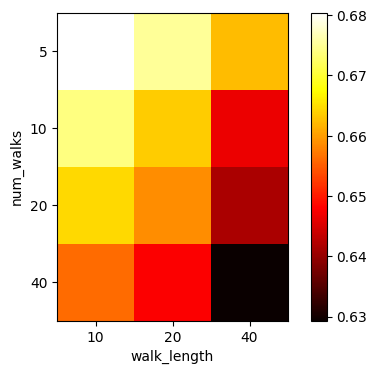

In [35]:
plt.figure(figsize=(6, 4))
node_dim = 20
# TODO: you should have an auc score dictionary here; build by trying difference walk lengths and num_walks
a = np.array([[deepwalk_auc_scores[(node_dim, num_walks, walk_length, 'valid')] for walk_length in [10, 20, 40]] for num_walks in [5, 10, 20, 40]])
plt.imshow(a, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.xticks(ticks=[0,1,2], labels=[10, 20, 40])
plt.xlabel("walk_length")
plt.yticks(ticks=[0,1,2,3], labels=[5, 10, 20, 40])
plt.ylabel("num_walks")

You can build model with the best parameters you find and save the prediction here.

In [36]:
model = build_deepwalk(graph, alias_nodes, node_dim=20, num_walks=10, walk_length=5)  # TODO
scores = [get_cosine_sim(model, src, dst) for src, dst in test_edges]
write_pred("data/pred.csv", test_edges, scores)

building a DeepWalk model...	number of walks: 727950	average walk length: 5.0000	training time: 41.7914


With the help of p and q, the node2vec model can fit training data better. And you can have a try if you set p=q=1, the two models will return the same results.

In [37]:
get_auc_score_test(model, test_edges, test_scores)

0.60828796125